# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Севастопольский Артем Михайлович

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [2]:
data_train = pd.read_csv('data/unimel_train.csv')
status_train = data_train['Grant.Status']
data_train = data_train.ix[:, ~data_train.columns.isin(('Grant.Status',))]    # dropping target column

data_test = pd.read_csv('data/unimel_test.csv')
status_test = data_test['Grant.Status']
data_test = data_test.ix[:, ~data_test.columns.isin(('Grant.Status',))]    # dropping target column

In [11]:
data_train.head()

,Grant.Application.ID,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1137,21A,50A,A,230202,50,230203,30,230204,20,...,3098,31,Yes,>=0 to 5,2,0,0,4,2,0
1,4314,4D,10A,D,320801,100,0,0,0,0,...,2553,25,Yes,>=0 to 5,3,1,0,2,0,0
2,2020,NaN,NaN,NaN,320602,50,321004,30,321015,20,...,2813,25,NaN,Less than 0,1,5,0,7,2,0
3,6777,51C,20C,A,291503,60,321402,40,0,0,...,2553,25,NaN,more than 15,2,1,5,6,9,1
4,409,24D,30B,NaN,380107,100,0,0,0,0,...,2923,25,NaN,Less than 0,0,2,0,0,0,0


In [4]:
print('{} objects, {} features'.format(*data_train.shape))

6095 objects, 39 features


In [5]:
data_test.head()

,Grant.Application.ID,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,5031,194B,30C,A,321015,100,0,0,0,0,...,2778,25,Yes,>=0 to 5,2,0,5,0,0,0
1,7856,84D,30B,A,320602,40,320503,60,0,0,...,2678,25,NaN,NaN,1,6,0,0,0,0
2,1122,21A,50A,A,390201,50,390301,30,390203,20,...,3658,22,NaN,>=0 to 5,0,1,0,0,0,0
3,5013,51C,20C,A,291404,100,0,0,0,0,...,2053,19,Yes,>=0 to 5,3,0,5,5,1,0
4,2140,NaN,NaN,NaN,300601,50,300699,25,270602,25,...,1098,1,Yes,>=0 to 5,0,1,3,18,8,12


In [6]:
print('{} objects, {} features'.format(*data_test.shape))

2613 objects, 39 features


#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

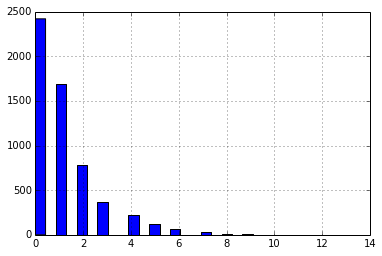

In [7]:
data_train['Number.of.Successful.Grant.1'].hist(bins=30)

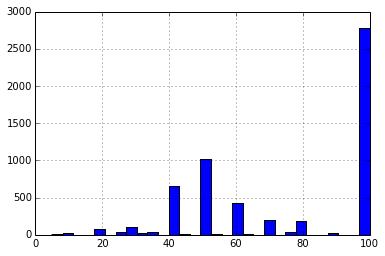

In [8]:
data_train['RFCD.Percentage.1'].hist(bins=30)

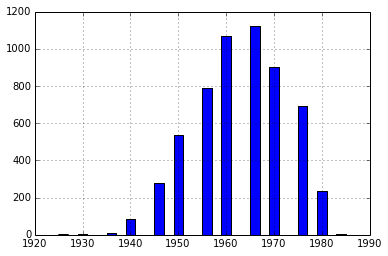

In [9]:
data_train['Year.of.Birth.1'].hist(bins=30)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

-----
Судя по графикам, признаки принимают не все значения на области, на которой они сосредоточены, а только некоторые:
* признак Number.of.Successful.Grant.1 принимает только целочисленные значения в диапазоне от 0 до 13
* признак RFCD.Percentage.1 &mdash; только некоторые значения в диапазоне от 5 до 100
* признак Year.of.Birth.1 &mdash; каждое пятое значение в своём диапазоне (1925, 1930, ...)

In [10]:
print(data_train['Number.of.Successful.Grant.1'].unique())
print(data_train['RFCD.Percentage.1'].unique())
print(data_train['Year.of.Birth.1'].unique())

[  2.   3.   1.   0.  nan   4.   5.   6.   8.   9.   7.  11.  13.  10.  12.]
[  50.  100.   60.   40.   80.   20.   70.   nan   75.   30.   25.   65.
   34.   85.   10.   90.   33.   15.   55.   45.   35.   51.    5.]
[ 1965.  1955.  1950.  1970.  1960.    nan  1945.  1980.  1940.  1975.
  1935.  1925.  1930.  1985.]


При этом в обучающей выборке объектов на пару порядков больше, чем значений их признаков. 

Масштабирование позволит уменьшить зазоры между значениями признаков на гистограмме.

Также значения разных признаков лежат в разных диапазонах, что может усложнить, к примеру, оптимизацию градиентным спуском. Поэтому для приведения значений признаков к одному диапазону их необходимо отмасштабировать.

-----

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [11]:
print 'Number of NaN cells in train:', data_train.isnull().sum(axis=0).sum()
print 'Number of rows in train with NaN value:', data_train.isnull().sum(axis=1).nonzero()[0].size
print 'Number of features in train with NaN value:', data_train.isnull().sum(axis=0).nonzero()[0].size

Number of NaN cells in train: 26843
Number of rows in train with NaN value: 5879
Number of features in train with NaN value: 38


Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [14]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [15]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}]


In [16]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
transformer.fit_transform(simple_data_dict)

array([[ 1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.]])

Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [3]:
def transform_data(data, scaler, transformer, is_test, to_scale=True):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    
    temp_data = data.copy()
    temp_data[numeric_cols] = temp_data[numeric_cols].fillna(value=0)
    categ_cols = temp_data.columns[~temp_data.columns.isin(numeric_cols)]
    temp_data[categ_cols] = temp_data[categ_cols].fillna(value='nan')
    temp_data[categ_cols] = temp_data[categ_cols].astype(str, copy=False)
    
    cat_dict = temp_data[categ_cols].T.to_dict().values()
    if not is_test:
        if to_scale:
            numeric_scaled = scaler.fit_transform(temp_data[numeric_cols])
        else:
            numeric_scaled = temp_data[numeric_cols].copy()
        categ_transformed = transformer.fit_transform(cat_dict)
    else:
        if to_scale:
            numeric_scaled = scaler.transform(temp_data[numeric_cols])
        else:
            numeric_scaled = temp_data[numeric_cols].copy()
        categ_transformed = transformer.transform(cat_dict)
    new_data = np.hstack((numeric_scaled, categ_transformed))
    
    return (new_data, scaler, transformer)

Применяем функцию к данным:

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [19]:
print X.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [18]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

clf_lr = LogisticRegression()
def predict_and_get_auc(clf, X_test, y_test):
    y_pred = clf.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

gs = GridSearchCV(estimator=clf_lr, param_grid={'C': C_grid, 'penalty': ['l2']}, 
                  scoring=predict_and_get_auc, n_jobs=1, cv=cv, verbose=1)
gs.fit(X, status_train)
print 'Best estimator:', gs.best_params_
print 'CV Score for best estimator:', gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   48.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best estimator: {'penalty': 'l2', 'C': 0.1}
CV Score for best estimator: 0.882391493452


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [74]:
gs = GridSearchCV(estimator=clf_lr, param_grid={'C': C_grid, 'penalty': ['l1']}, 
                  scoring=predict_and_get_auc, n_jobs=1, cv=cv, verbose=1)
gs.fit(X, status_train)
print 'Best estimator:', gs.best_params_
print 'CV Score for best estimator:', gs.best_score_

for C in C_grid:
    clf_lr = LogisticRegression(C=C, penalty='l1')
    clf_lr.fit(X, status_train)
    print 'C={}, number of nonzero coefficients: {}'.format(C, np.nonzero(clf_lr.coef_)[0].size)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.3min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best estimator: {'penalty': 'l1', 'C': 1.0}
CV Score for best estimator: 0.880449712554
C=0.001, number of nonzero coefficients: 0
C=0.01, number of nonzero coefficients: 9
C=0.1, number of nonzero coefficients: 58
C=1.0, number of nonzero coefficients: 669
C=10.0, number of nonzero coefficients: 2448
C=100.0, number of nonzero coefficients: 2983


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [75]:
clf_lr = LogisticRegression(C=0.01, penalty='l1')
clf_lr.fit(X, status_train)
print 'Test score: ', predict_and_get_auc(clf_lr, X_test, status_test)
print 'LR coefficients: used {} / all {}'.format(np.nonzero(clf_lr.coef_)[0].size, clf_lr.coef_.size)

Test score:  0.852545565192
LR coefficients: used 9 / all 11734


#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [76]:
C_best = 0.1
clf_lr = LogisticRegression(C=C_best, penalty='l2')
clf_lr.fit(X, status_train)
status_pred_proba = clf_lr.predict_proba(X_test)[:, 1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [77]:
from sklearn.metrics import average_precision_score, log_loss
print 'AUC-ROC: ', roc_auc_score(status_test, status_pred_proba)
print 'AUC-PR:  ', average_precision_score(status_test, status_pred_proba)
print 'log-loss:', log_loss(status_test, status_pred_proba)

AUC-ROC:  0.880349059919
AUC-PR:   0.838758043121
log-loss: 0.442737702403


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

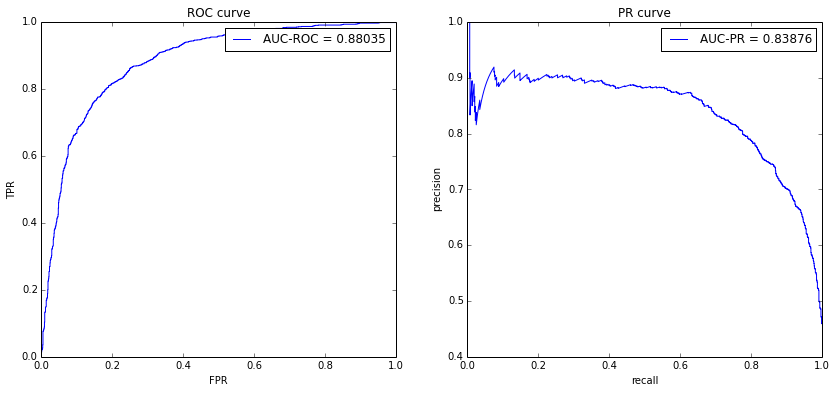

In [100]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
fpr, tpr, _ = roc_curve(status_test, status_pred_proba)
roc_auc = auc(fpr, tpr)
pr, rec, _ = precision_recall_curve(status_test, status_pred_proba)
pr_auc = average_precision_score(status_test, status_pred_proba)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].set_title('ROC curve')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].plot(fpr, tpr, label='AUC-ROC = {:.5}'.format(roc_auc))
axes[0].legend()

axes[1].set_title('PR curve')
axes[1].set_xlabel('recall')
axes[1].set_ylabel('precision')
axes[1].plot(rec, pr, label='AUC-PR = {:.5}'.format(pr_auc))
axes[1].legend()

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(status_test, status_pred_proba)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, label='AUC-ROC = {:.5}'.format(roc_auc))
plt.legend()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [138]:
pr, rec, thr = precision_recall_curve(status_test, status_pred_proba)
pr_opt = pr[rec >= 0.9].max()
print 'Maximal precision when recall is >= 0.9:', pr_opt
idx_opt = np.where((pr == pr_opt) & (rec >= 0.9))[0][0]
thr_opt = thr[idx_opt]
print 'Threshold:', thr_opt

Maximal precision when recall is >= 0.9: 0.701948051948
Threshold: 0.314958503338


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [139]:
pr, rec, thr = precision_recall_curve(status_test, status_pred_proba)
idx_opt = np.where((pr == pr_opt) & (rec >= 0.9))[0][0]
thr_opt, pr_opt, rec_opt = thr[idx_opt], pr[idx_opt], rec[idx_opt]
print 'Precision: ', pr_opt
print 'Recall: ', rec_opt
f = 2 * pr_opt * rec_opt / float(pr_opt + rec_opt)
print 'F score: ', f

Precision:  0.701948051948
Recall:  0.900083263947
F score:  0.7887632251


-----
F-мера &mdash; это среднее гармоническое точности и полноты, а среднее гармоническое двух чисел мало тогда, когда хотя бы одно из них мало. Это объясняется, к примеру, значением следующего предела:

$$ \lim_{a \rightarrow 0} \frac{2ab}{a+b} = \lim_{b \rightarrow 0} \frac{2ab}{a+b} = \lim_{a \rightarrow 0} \frac{2}{\frac{1}{a} + \frac{1}{b}} = 0$$

-----

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [135]:
pr, rec, thr = precision_recall_curve(status_test, status_pred_proba)
rec_opt = rec[pr >= 0.8].max()
print 'Maximal recall when precision is >= 0.8:', rec_opt
idx_opt = np.where((rec == rec_opt) & (pr >= 0.8))[0][0]
thr_opt, pr_opt = thr[idx_opt], pr[idx_opt]
print 'Precision: ', pr_opt
print 'Threshold: ', thr_opt

f = 2 * pr_opt * rec_opt / float(pr_opt + rec_opt)
print 'F score: ', f

Maximal recall when precision is >= 0.8: 0.776019983347
Precision:  0.8
Threshold:  0.529039415988
F score:  0.787827557058


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [148]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios, '*-')

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

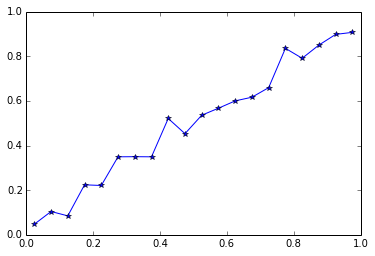

In [150]:
clf = LogisticRegression(C=1.0)
clf.fit(X, status_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(status_test, preds)

-----
Да, кривая получилась почти диагональной.

-----

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

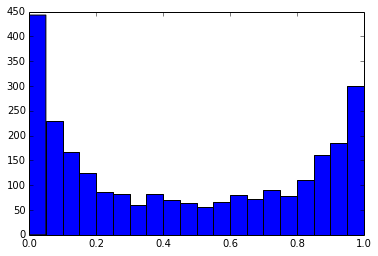

In [151]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [153]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, status_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

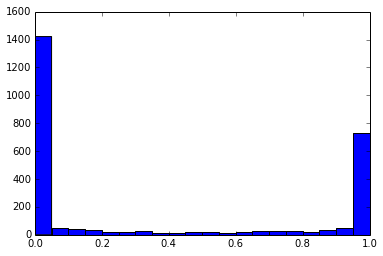

In [155]:
plt.hist(preds, bins=20)
plt.show()

-----
На последнем графике видно, что большинство значений сконцентрированы вблизи 0.0 или 1.0. Сигмоида близка к 0, 
когда её аргумент близок к $-\infty,$ и к 1, когда её аргумент близок к $+\infty$. Классификатор с hinge loss штрафует объекты за попадание в полосу около разделяющей прямой, поэтому большинство объектов расположено вне данной полосы, и аргумент сигмоиды в основном не близок к нулю.

-----

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

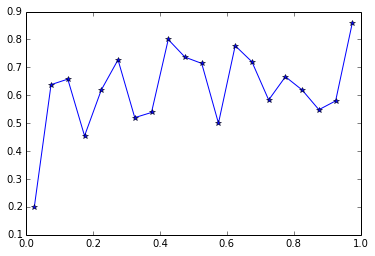

In [158]:
plot_calibration_curve(status_test, preds)

-----
Калибровочная кривая не близка к диагональной.

-----

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

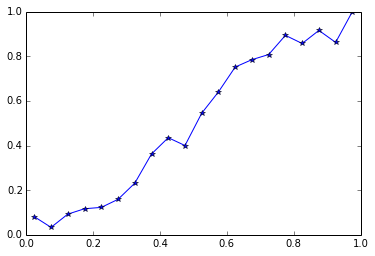

In [169]:
from sklearn.calibration import CalibratedClassifierCV

clf_calibrd = CalibratedClassifierCV(base_estimator=clf)
clf_calibrd.fit(X, status_train)
preds = clf_calibrd.predict_proba(X_test)[:, 1]
plot_calibration_curve(status_test, preds)

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

![Australia one love](Australia one love.jpg)

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [15]:
Xn = np.hstack((np.ones((X.shape[0], 1)), X))
yn_train = status_train.copy()
yn_train[yn_train == 0] = -1

Xn_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
yn_test = status_test.copy()
yn_test[yn_test == 0] = -1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [4]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    pred_proba = X.dot(w)
    return pred_proba

In [5]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    N, D = X.shape
    exp_arg_terms = -y.reshape((N, 1)) * X * w.reshape((1, D))
    exp_arg_max_min = exp_arg_terms.max(axis=1) - exp_arg_terms.min(axis=1)
    exp_arg = exp_arg_terms.sum(axis=1) - exp_arg_max_min
    cost = (exp_arg_max_min + \
        np.log(np.exp(-exp_arg_max_min) + np.exp(exp_arg))).sum()
    return cost

In [6]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    N, D = X.shape
    exp_arg_terms = y.reshape((N, 1)) * X * w.reshape((1, D))
    exp_arg_max_min = exp_arg_terms.max(axis=1) - exp_arg_terms.min(axis=1)
    exp_arg = exp_arg_terms.sum(axis=1) - exp_arg_max_min
    grad = -((y * np.exp(-exp_arg_max_min) / \
             (np.exp(-exp_arg_max_min) + np.exp(exp_arg))).reshape((N, 1)) * X).sum(axis=0)
    return grad

-----
Функции подсчета целевой функции и её градиента реализованы с выделением главной части экспоненты для большей численной устойчивости.

Для проверки правильности подсчета градиента подсчитанный градиент сравнивается с его разностным приближением.

In [118]:
def compute_gradient(J, theta, eps=1e-6):
    '''
    Accepts:
    J - function that returns loss - float
    theta - numpy.ndarray - point where gradient must be computed
    eps - float, optional - calculations precision
    Returns:
    grad - approximate value of gradient at point theta
    '''

    D = theta.size
    grad = np.empty(D, dtype=np.float64)
    shift = np.zeros(D, dtype=np.float64)
    for i in range(D):
        if i > 0:
            shift[i - 1] = 0
        shift[i] += eps
        grad[i] = (J(theta + shift) - J(theta - shift)) / eps / 2.0
    return grad


def check_gradient_eq(grad, numer_grad, eps=1e-6):
    '''
    Accepts:
    grad - numpy.ndarray - true gradient of J at point theta
    numer_grad - numpy.ndarray - computer gradient of J at point theta
    Returns:
    True or False - whether numerical gradient is equal to computed
    '''
    
    if not np.all(np.abs(grad - numer_grad) < eps):
        print(("ERROR: gradient is incorrect.\n"
               "gradient: {}\n"
               "numerical gradient: {}").format(grad, numer_grad))
        return False
    print("OK")
    return True

In [119]:
features = 25
w = np.random.rand(features)
grad = get_grad(w, Xn[:, :features], yn_train)
grad_numer = compute_gradient(lambda w: get_func(w, Xn[:, :features], yn_train), w)
check_gradient_eq(grad, grad_numer)

OK


True

-----

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [17]:
def converged(w, prev_obj, obj, tol=1e-6, criterion='objective'):
    '''Accepted values for criterion:
    'objective' -- stop when objective function is small,
    'value' -- stop when norm of vector being optimized is small.
    '''
    
    if criterion == 'objective':
        return (abs(obj - prev_obj) < tol)
    elif criterion == 'value':
        return ((w * w).sum() < tol * tol)
    return None


def grad_descent(X, y, step_size, max_iter, stop_criterion='objective'):
    '''Accepted values for stop_criterion:
    'objective' -- stop when objective function is small,
    'value' -- stop when norm of vector being optimized is small.
    '''
    tol = 1e-6
    
    N, D = X.shape
    w = np.random.rand(D) * 2
    obj = [float('inf'), get_func(w, X, y)]
    iter_num = 0
    
    while not converged(w, obj[-2], obj[-1], tol, stop_criterion) and iter_num < max_iter:
        grad = get_grad(w, X, y)
        #grad /= np.linalg.norm(grad)
        w -= step_size * grad
        
        obj.append(get_func(w, X, y))
        #if not np.isfinite(obj[-1]):
        #    w = np.random.rand(D) * 2   # re-initialization
        
        iter_num += 1
    
    obj = obj[1:]
    return (w, obj)

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

GD completed for step_size=1e-05
GD completed for step_size=0.0001
GD completed for step_size=0.001
GD completed for step_size=1.0
GD completed for step_size=10.0


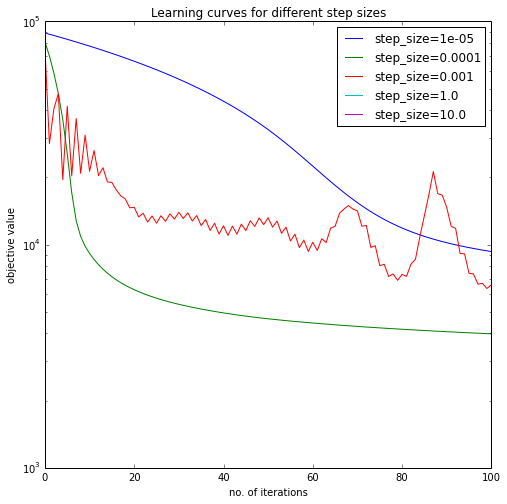

In [121]:
step_grid = [0.00001, 0.0001, 0.001, 1.0, 10.0]

plt.figure(figsize=(8, 8))
plt.title('Learning curves for different step sizes')
plt.xlabel('no. of iterations')
plt.ylabel('objective value')
ws = []
for step_size in step_grid:
    w, obj = grad_descent(Xn, yn_train, step_size, max_iter=100, stop_criterion='objective')
    print 'GD completed for step_size={}'.format(step_size)
    plt.semilogy(np.arange(len(obj)), obj, label='step_size={}'.format(step_size))
    ws.append(w)
plt.legend()

По траекториям видно, что некоторые из выбранных размеров шага приводят к медленной сходимости к решению (например, синяя кривая), некоторые -- к быстрой (красная). Судя по красной кривой, метод пропускает оптимум, затем возвращается, идя в другую сторону, затем делает шаг в прежнюю сторону и т.д.

In [133]:
i_best = 1

w_best = ws[i_best]
yn_pred_proba = make_pred(Xn_test, w_best)
roc_auc = roc_auc_score(yn_test, yn_pred_proba)
print 'ROC-AUC for best option:', roc_auc

ROC-AUC for best option: 0.797763844105


Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [19]:
def sgd(X, y, step_size, max_iter, stop_criterion='objective'):
    '''Accepted values for stop_criterion:
    'objective' -- stop when objective function is small,
    'value' -- stop when norm of vector being optimized is small.
    '''
    tol = 1e-6
    
    N, D = X.shape
    w = np.random.rand(D) * 2
    obj = [float('inf'), get_func(w, X, y)]
    iter_num = 0
    
    while not converged(w, obj[-2], obj[-1], tol, stop_criterion) and iter_num < max_iter:
        i = np.random.randint(low=0, high=N)
        X_sub = X[i:i+1]
        y_sub = y[i:i+1]
        grad = get_grad(w, X_sub, y_sub)
        #print 'grad:', grad
        #grad /= np.linalg.norm(grad)
        w -= step_size * grad
        #print 'w:', w
        
        obj.append(get_func(w, X, y))
        #print 'obj:', obj
        if not np.isfinite(obj[-1]):
            w = np.random.rand(D) * 2   # re-initialization
        #print 'w:', w
        
        iter_num += 1
    
    obj = obj[1:]
    return (w, obj)

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

SGD completed for step_size=0.0001
ROC-AUC=0.523137883209 for step_size=0.0001
SGD completed for step_size=0.001
ROC-AUC=0.540425176847 for step_size=0.001
SGD completed for step_size=0.01
ROC-AUC=0.502576052062 for step_size=0.01
SGD completed for step_size=0.1
ROC-AUC=0.501362474142 for step_size=0.1
SGD completed for step_size=1.0
ROC-AUC=0.640479310207 for step_size=1.0
SGD completed for step_size=3.0
ROC-AUC=0.451207150321 for step_size=3.0


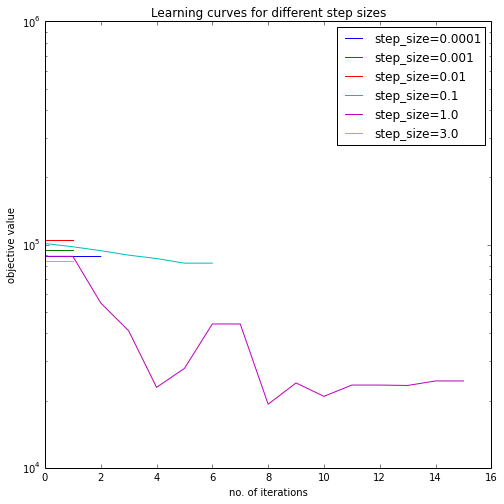

In [143]:
step_grid = [0.0001, 0.001, 0.01, 0.1, 1.0, 3.0]

plt.figure(figsize=(8, 8))
plt.title('Learning curves for different step sizes')
plt.xlabel('no. of iterations')
plt.ylabel('objective value')
for step_size in step_grid:
    w, obj = sgd(Xn, yn_train, step_size, max_iter=100, stop_criterion='objective')
    print 'SGD completed for step_size={}'.format(step_size)
    plt.semilogy(np.arange(len(obj)), obj, label='step_size={}'.format(step_size))
    
    yn_pred = make_pred(Xn_test, w)
    roc_auc = roc_auc_score(yn_test, yn_pred)
    print 'ROC-AUC={} for step_size={}'.format(roc_auc, step_size)
plt.legend()

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [9]:
# transforming data
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X2, scaler, transformer = transform_data(data_train, scaler, transformer, False, to_scale=False)
X2_test, _, _ = transform_data(data_test, scaler, transformer, True, to_scale=False)

In [10]:
# adding all-ones feature
X2n = np.hstack((np.ones((X2.shape[0], 1)), X2))
X2n_test = np.hstack((np.ones((X2_test.shape[0], 1)), X2_test))

SGD completed for step_size=0.0001
ROC-AUC=0.474894917597 for step_size=0.0001
SGD completed for step_size=0.001
ROC-AUC=0.505671324416 for step_size=0.001
SGD completed for step_size=0.01
ROC-AUC=0.496936275955 for step_size=0.01
SGD completed for step_size=0.1
ROC-AUC=0.466301983946 for step_size=0.1
SGD completed for step_size=1.0
ROC-AUC=0.5236497324 for step_size=1.0
SGD completed for step_size=3.0
ROC-AUC=0.500083440853 for step_size=3.0


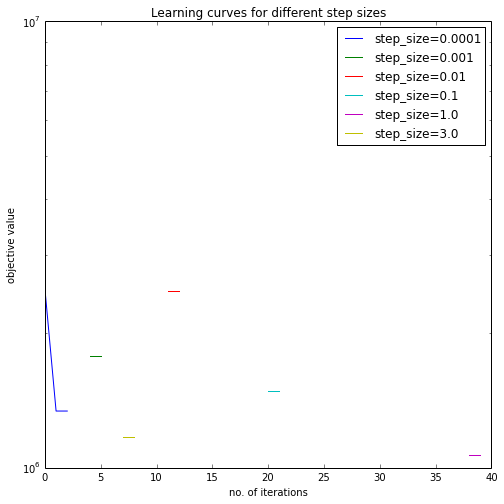

In [22]:
# running SGD, plotting results, computing AUC-ROC
step_grid = [0.0001, 0.001, 0.01, 0.1, 1.0, 3.0]

plt.figure(figsize=(8, 8))
plt.title('Learning curves for different step sizes')
plt.xlabel('no. of iterations')
plt.ylabel('objective value')
for step_size in step_grid:
    w, obj = sgd(X2n, yn_train, step_size, max_iter=100, stop_criterion='objective')
    print 'SGD completed for step_size={}'.format(step_size)
    plt.semilogy(np.arange(len(obj)), obj, label='step_size={}'.format(step_size))
    
    yn_pred_proba = make_pred(X2n_test, w)
    roc_auc = roc_auc_score(yn_test, yn_pred_proba)
    print 'ROC-AUC={} for step_size={}'.format(roc_auc, step_size)
plt.legend()

Здесь вы можете поделиться своими мыслями по поводу этой части.

-----
Основными проблемами, возникшими при отладке градиентного спуска, были большое время оптимизации и численная неустойчивость. Большое время оптимизации было вызвано в первую очередь объемом данных (в данных более 11000 признаков). Численная неустойчивость возникала из-за потенцирования, а затем логарифмирования слишком больших или слишком маленьких чисел. В связи с этим было реализовано выделение главной части экспоненты, что в свою очередь еще повысило время работы (прозводится больше сложных арифметических операций). Градиентный спуск работает на порядки дольше стохастического градиентного спуска, но последний останавливается на первых итерациях и достигает из-за этого низкого качества. Также можно видеть, что масштабирование признаков обязательно для проведения оптимизации методом градиентного спуска.

-----

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [2]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

for alpha in alpha_grid:
    regr_lr = Ridge(alpha=alpha)
    regr_lr.fit(X, y)
    y_pred = regr_lr.predict(X_test)
    score = mean_squared_error(y_pred, y_test)
    print 'Score for alpha={}: {}'.format(alpha, score)

Score for alpha=0.001: 3120.09020578
Score for alpha=0.01: 3107.38818648
Score for alpha=0.1: 3096.03015101
Score for alpha=1.0: 3399.40482339
Score for alpha=10.0: 4577.48210429
Score for alpha=100.0: 5210.22019186


-----
Наилучшее качество достигается при $\alpha = 0.1$.

-----

Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [9]:
from sklearn.metrics import r2_score

alpha_best = 0.1
regr_lr = Ridge(alpha=alpha_best)
regr_lr.fit(X, y)
y_pred = regr_lr.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R2 score:', score

R2 score: 0.417024184822


-----
Коэффициент детерминации лежит в диапазоне от 0 до 1. Модель лучше объясняет разнородность данных, когда её коэффициент детерминации близок к 1. В данном случае коэффициент менее 0.5. Можно сказать, что модель описывает (объясняет) не более 30% разброса в данных (согласно таблице на сайте http://people.duke.edu/~rnau/rsquared.htm).

-----